# **Autoencoder denoiser**

### A CNN to denoise corrupted images based on Fashion MNIST dataset.

Autoencoder architecture provides an encoded latent space of reduced features which can be decoded back to its original form.

Autoencoder is an unsupervised methodology similar, but more flexible than Principal Component Analysis (PCA). It doesn't resemble the probabilistic distribution unlike Variational Auto Encoders.

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

## 1. Dataset

### 1.1 Load the dataset
In this case we are loading dataset separately for train and test dataset.

We include an artificial noise to the image.

In [2]:
train_dataset, test_dataset = tfds.load('fashion_mnist', as_supervised=True, split=['train', 'test'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteHD73O9/fashion_mnist-train.tfrecord*...:   0…

Generating test examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/fashion_mnist/3.0.1.incompleteHD73O9/fashion_mnist-test.tfrecord*...:   0%…

Dataset fashion_mnist downloaded and prepared to /root/tensorflow_datasets/fashion_mnist/3.0.1. Subsequent calls will reuse this data.


### 1.2 Normalize and add noise
- Normalize the values to the range of 0-1
- Intentionally corrupt the dataset with random noise.
- We want a grainy pictures, not a slight noise.
- **Important: we replace the classification labels with original images. We want to compare images instead of classifying them.**

In [3]:
def add_noise(image, label):
    image = tf.cast(image, dtype=tf.float32)
    image /= 255.0

    noise = tf.random.normal(shape=image.shape)
    noise *= 0.5

    noise_image = image + noise
    noise_image = tf.clip_by_value(noise_image, 0.0, 1.0)

    return noise_image, image

### 1.3 Process the images in datasets

In [4]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = train_dataset.map(add_noise)
test_dataset = test_dataset.map(add_noise)

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

### 1.4 Preview the noisy images
*By the way -  brain processing according to gestalt principles and top-down visual perception mostly makes it trivial to guess what's on the picture - but some of them doesn't look like they contain anything at all. It's fascinating how AI can handle that.*

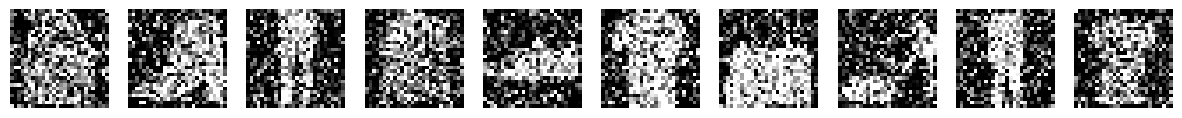

In [5]:
plt.figure(figsize=(15, 5))

row = 1
for image, label in train_dataset.take(10):
    plt.subplot(1, 10, row)
    plt.imshow(image[0], cmap='gray')
    plt.axis('off')
    row += 1

## 2. Create the Model

**Autoencoder consists of 3 building blocks:**
- **Encoder:** Reduce dimensions to low-dimensional latent space.
- **Bottleneck:** The most compressed representation of our data.
- **Decoder:** Decodes the image from it's compressed form.

Instead of sequential or functional API, these building blocks are made as classes.

### 2.1 Encoder

In [6]:
class Encoder(tf.keras.Model):
    def __init__(self):
        super(Encoder, self).__init__()
        self.conv_1 = tf.keras.layers.Conv2D(filters=64, 
                                             kernel_size=(3,3), 
                                             activation='relu', 
                                             padding='same')

        self.maxpool_1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))

        self.conv_2 = tf.keras.layers.Conv2D(filters=128, 
                                             kernel_size=(3,3), 
                                             activation='relu', 
                                             padding='same')

        self.maxpool_2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))


    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.maxpool_1(x)
        x = self.conv_2(x)
        x = self.maxpool_2(x)
        return x

### 2.2 Bottleneck

In [7]:
class Bottleneck(tf.keras.Model):
    def __init__(self):
        super(Bottleneck, self).__init__()
        self.bottleneck = tf.keras.layers.Conv2D(filters=256, 
                                                 kernel_size=(3,3), 
                                                 activation='relu', 
                                                 padding='same')

        self.encoder_visualization = tf.keras.layers.Conv2D(filters=1, 
                                                            kernel_size=(3,3), 
                                                            name='encoder_visualization',
                                                            activation='sigmoid', 
                                                            trainable=False,
                                                            padding='same')

    def call(self, inputs):
        x = self.bottleneck(inputs)
        vis = self.encoder_visualization(x)
        return x, vis

### 2.3 Decoder

In [8]:
class Decoder(tf.keras.Model):
    def __init__(self):
        super(Decoder, self).__init__()
        self.conv_1 = tf.keras.layers.Conv2D(filters=128, 
                                             kernel_size=(3,3), 
                                             activation='relu', 
                                             padding='same')
        
        self.upsample_1 = tf.keras.layers.UpSampling2D(size=(2,2))

        self.conv_2 = tf.keras.layers.Conv2D(filters=64, 
                                             kernel_size=(3,3), 
                                             activation='relu', 
                                             padding='same')
        
        self.upsample_2 = tf.keras.layers.UpSampling2D(size=(2,2))

        self.conv_3 = tf.keras.layers.Conv2D(filters=1, 
                                             kernel_size=(3,3), 
                                             activation='sigmoid', 
                                             padding='same')

    def call(self, inputs):
        x = self.conv_1(inputs)
        x = self.upsample_1(x)
        x = self.conv_2(x)
        x = self.upsample_2(x)  
        x = self.conv_3(x)
        return x

### 2.4 Autoencoder model
Merge each subclasses into the final Autoencoder model.

**Keras subclass API provides great flexibility but differers from functional and sequential API:**
- You can customize every function but bugs are harder to track.
- To build the model you have to pass it's initial input shape `RAW_INPUT_SHAPE`
- Model summary doesn't provide the output sizes unless you create a customized summary function which passes the input shape and then calls summary.

*Autoencoder might be too basic for this kind of development because of many boilerplate code necessary.*

**TODO: Custom compile and training loop**


In [9]:
class AutoEncoder(tf.keras.Model):
    def __init__(self):
        super(AutoEncoder, self).__init__()

        self.encoder = Encoder()
        self.bottleneck = Bottleneck()
        self.decoder = Decoder()


    def call(self, inputs):

        x = self.encoder(inputs)
        x, _ = self.bottleneck(x)
        x = self.decoder(x)
        return x


    def summary(self, shape):
        x = tf.keras.layers.Input(shape=shape)
        temp_model = tf.keras.Model(inputs=x, outputs=self.call(x))
        return temp_model.summary()


INPUT_SHAPE = (28,28,1)
RAW_INPUT_SHAPE = (1, *INPUT_SHAPE)

denoise_model = AutoEncoder()
denoise_model.build(RAW_INPUT_SHAPE)
denoise_model.summary(INPUT_SHAPE)

# denoise_model.encoder.summary()
# denoise_model.bottleneck.summary()
# denoise_model.decoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Encoder)           (None, 7, 7, 128)         74496     
                                                                 
 bottleneck (Bottleneck)     ((None, 7, 7, 256),       297473    
                              (None, 7, 7, 1))                   
                                                                 
 decoder (Decoder)           (None, 28, 28, 1)         369409    
                                                                 
Total params: 741,378
Trainable params: 739,073
Non-trainable params: 2,305
_________________________________________________________________


## 3. Compile and train

In [10]:
TRAIN_STEPS = 60000 // BATCH_SIZE
VALID_STEPS = 60000 // BATCH_SIZE
EPOCHS = 40

denoise_model.compile(
    optimizer=tf.keras.optimizers.Adam(), 
    loss=tf.keras.losses.BinaryCrossentropy()
)

denoise_model_history = denoise_model.fit(train_dataset, steps_per_epoch=TRAIN_STEPS, validation_data=test_dataset, validation_steps=VALID_STEPS, epochs=EPOCHS)

Epoch 1/40
468/468 [==============================] - 36s 44ms/step - loss: 0.3219 - val_loss: 0.3002
Epoch 2/40
468/468 [==============================] - 19s 39ms/step - loss: 0.2950 - val_loss: 0.2952
Epoch 3/40
468/468 [==============================] - 16s 33ms/step - loss: 0.2906 - val_loss: 0.2911
Epoch 4/40
468/468 [==============================] - 14s 31ms/step - loss: 0.2879 - val_loss: 0.2891
Epoch 5/40
468/468 [==============================] - 14s 30ms/step - loss: 0.2861 - val_loss: 0.2875
Epoch 6/40
468/468 [==============================] - 14s 30ms/step - loss: 0.2849 - val_loss: 0.2863
Epoch 7/40
468/468 [==============================] - 15s 32ms/step - loss: 0.2840 - val_loss: 0.2857
Epoch 8/40
468/468 [==============================] - 15s 32ms/step - loss: 0.2832 - val_loss: 0.2849
Epoch 9/40
468/468 [==============================] - 16s 34ms/step - loss: 0.2825 - val_loss: 0.2845
Epoch 10/40
468/468 [==============================] - 15s 32ms/step - loss: 0.282

## 4. Results

### 4.1 Visualization helper model
A helper model to reach the most compressed input representation inside the bottleneck. It's a subclass of Autoencoder but returns the helper layer instead of passing data to decoder.

In [11]:
class Encoder_visualization(tf.keras.Model):
    def __init__(self):
        super(Encoder_visualization, self).__init__()
        self.encoder = denoise_model.encoder
        self.bottleneck = denoise_model.bottleneck
    

    def call(self, inputs):
        x = self.encoder(inputs)
        _, vis = self.bottleneck(x)

        return vis


encoder_visualization_model = Encoder_visualization()
encoder_visualization_model.build(RAW_INPUT_SHAPE)
encoder_visualization_model.summary()

Model: "encoder_visualization"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           (None, 7, 7, 128)         74496     
                                                                 
 bottleneck (Bottleneck)     ((None, 7, 7, 256),       297473    
                              (None, 7, 7, 1))                   
                                                                 
Total params: 371,969
Trainable params: 369,664
Non-trainable params: 2,305
_________________________________________________________________


### 4.2 Display denoising result

In [14]:
def display_one_row(disp_images, offset, shape):
    for index, noisy_image in enumerate(disp_images):
        plt.subplot(3, 10, offset + index + 1)
        plt.xticks([])
        plt.yticks([])
        noisy_image = np.reshape(noisy_image, shape)
        plt.imshow(noisy_image, cmap='gray')


def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape):
    plt.figure(figsize=(15, 5))
    display_one_row(disp_input_images, 0, shape=(28,28))
    display_one_row(disp_encoded, 10, shape=enc_shape)
    display_one_row(disp_predicted, 20, shape=(28,28))

1/1 [==============================] - 0s 20ms/step


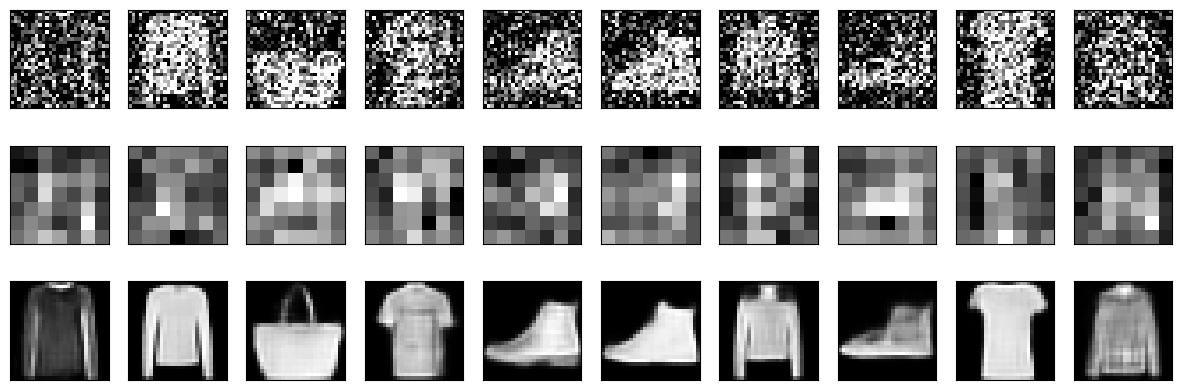

In [32]:
TEST_BATCH = test_dataset.take(1)
PREVIEW_AMOUNT = 10
INDEX = np.random.randint(0, BATCH_SIZE, size=PREVIEW_AMOUNT)

output_samples = []
for input_image, image in tfds.as_numpy(TEST_BATCH):
    output_samples = input_image

output_samples = np.array(output_samples[INDEX])

encoded = encoder_visualization_model.predict(output_samples)
predicted = denoise_model.predict(output_samples)

display_results(output_samples, encoded, predicted, enc_shape=(7,7))